# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an idea of a possible approach.**_

## Setup

In [1]:
import json
import pathlib
import urllib.parse
import os
import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
import sqlalchemy as db
import psycopg2
import geodatasets
import warnings

from matplotlib.lines import Line2D
from matplotlib.widgets import RangeSlider
from sqlalchemy import create_engine
from sqlalchemy.orm import declarative_base

In [2]:
# Where data files will be read from/written to
DATA_DIR = pathlib.Path("./data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "8ITaLVGKJEzelLCfrNyuIi2rJ"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/resource/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"
NYC_DATA_nypd='uip8-fykc.geojson'

DB_NAME = "project_database_final3"
DB_USER = "qianzhuoxin"
DB_URL = f"postgresql://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [3]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():

    QUERY_DIR.mkdir()

## Part 1: Data Preprocessing

#### This section shows how we successfully load the five data files, we cleaned all the dataframes to clean, normalize and ensure the correct and consistent data types and dataframe types. We selected the columns based on the queries included in Part 3 and 4.

#### Downloads a GeoJSON file from a specified URL and saves it with a given filename

In [4]:
def download_nyc_geojson_data(url: str, jsonname: str,force: bool = False) -> str:
    """
    Arguments: 
        url: URL from which to download the GeoJSON data.
        jsonname: filename where the downloaded data will be saved.
        force: if set to True, the file will be downloaded again no matter whether it's existed.
               False as default
    
    Returns:
        the name of the file where the downloaded data is saved.
    """
    
    parsed_url = urllib.parse.urlparse(url)
    url_path = parsed_url.path.strip("/")
    
    filename = DATA_DIR / (url_path.split('/')[-1])
    
    if force or not filename.exists():
        print(f"Downloading {url} to {jsonname}...")
        response = requests.get(url)
        response.raise_for_status()
       
        with open(jsonname, "a") as f:
            json.dump(response.json(), f)
        print(f"Done downloading {url}.")
    else:
        print(f"Reading from {jsonname}...")

    return jsonname

In [5]:
def clean_311_data(df: pd.DataFrame) -> gpd.GeoDataFrame:
    """
    Argument:
        pandas dataframe
    
    Return: 
        A GeoDataFrame with cleaned and transformed 311 service request data
    """
    columns = ['unique_key', 'created_date', 'incident_zip', 'complaint_type', 'longitude', 'latitude']
    df_selected = df[columns]
    df_selected = df_selected.dropna(axis = 0)
    
    df_selected.rename(columns = {'incident_zip': 'zipcode'}, inplace=True)
    df_selected['zipcode'] = df_selected['zipcode'].astype(int)
    df_selected.rename(columns = {'unique_key': 'id'}, inplace=True)
    df_selected.rename(columns = {'created_date': 'date'}, inplace=True)
    df_selected['geometry'] = gpd.points_from_xy(df_selected['longitude'], df_selected['latitude'], crs = "EPSG:4326")
    df_selected = df_selected.drop(['latitude','longitude'],axis = 1)
    df_selected['date'] = pd.to_datetime(df_selected['date']).dt.strftime('%Y-%m-%d')
    df_selected['date'] = pd.to_datetime(df_selected['date']).dt.date
    
    return gpd.GeoDataFrame(df_selected,geometry = 'geometry')

In [6]:
def download_311_data(offset: int) -> pd.DataFrame:
    """
    Argument:
        offset: show where data retrieval should start

    Returns:
        a pandas dataframe containing the downloaded 311 service request data
    """
    base_url = f"{BASE_NYC_DATA_URL}{NYC_DATA_311}?$$app_token={NYC_DATA_APP_TOKEN}"
    url = (
        f'{base_url}&$limit=1000000&$offset={offset}'
        f'&$where=created_date between "2018-01-01T12:00:00.000" '
        f'and "2023-09-30T12:00:00.000"'
    )
    download_nyc_geojson_data(
        url, jsonname=f'query_{offset/1000000+1}_data.geojson', force=False
    )
    print('begin to create csv')
    df = gpd.read_file(f'query_{offset/1000000+1}_data.geojson')
    print('finishing create csv')
    csv_filename = f'query_{offset/1000000+1}_data.csv'
    df.to_csv(csv_filename, index=False)
    return pd.read_csv(csv_filename)

In [7]:
def load_311_data(offset:int = 1000000) -> pd.DataFrame:
    """
    Arguments:
        offset: show where data retrieval should start

    Returns:
        a pandas dataframe containing the downloaded 311 service request data
    """
    i = 1
    flag = True

    while flag:
        filename = f"query_{i}_data.csv"
        pathname = DATA_DIR / 'data311'/filename
        if pathname.exists():
            df = pd.read_csv(pathname)
        else:
            df = download_311_data(i*offset)
        if i == 1:
            df_311 = df
        else:
            df_311 = pd.concat([df_311,df])
        flag = df.shape[0]==offset
        i += 1
    return clean_311_data(df_311)

### zipcode data

In [8]:
def load_and_clean_zipcodes(ZIPCODE_DATA_FILE: pathlib.PosixPath) -> gpd.GeoDataFrame:
    """
    Argument:
        zipcode_datafile: The file path to the geospatial data file

    Returns:
        gpd.GeoDataFrame: a cleaned and processed GeoDataFrame
    """
    gdf = gpd.read_file(ZIPCODE_DATA_FILE)
    #normalized data
    gdf_normalized = gdf.to_crs(epsg=4326)
    
    #selected_zipcode
    columns=['ZIPCODE', 'PO_NAME', 'STATE','COUNTY','geometry']
    gdf_selected=gdf_normalized[columns]
    gdf_selected.rename(columns={'ZIPCODE': 'zipcode'}, inplace=True)
    gdf_selected.rename(columns={'COUNTY': 'county'}, inplace=True)
    gdf_selected.rename(columns={'STATE': 'state'}, inplace=True)
    gdf_selected.rename(columns={'PO_NAME': 'poname'}, inplace=True)
    
    #cleaned_zipcode
    gdf_cleaned = gdf_selected.dropna()
    gdf_cleaned.insert(0,"id", gdf_cleaned.index)
    return gdf_cleaned

### tree data

In [9]:
def download_tree_data():
    """
    Returns:
        a pandas DataFrame containing the tree data downloaded from the NYC Open Data source.
    """
    base_url = f"{BASE_NYC_DATA_URL}{NYC_DATA_TREES}?$$app_token={NYC_DATA_APP_TOKEN}"
    url = f'{base_url}&$limit=1000000'
    download_nyc_geojson_data(url,jsonname = 'nyc_tree.geojson',force = False)
    df = gpd.read_file('nyc_tree.geojson')
    df.to_csv('nyc_tree.csv',index = False)
    
    df_read = pd.read_csv("nyc_tree.csv")
    return df_read

In [10]:
def clean_tree_data(df: pd.DataFrame) -> gpd.GeoDataFrame: 
    """
    Argument:
        pandas dataframe
    
    Return: 
        A GeoDataFrame with cleaned and transformed tree data
    """
    columns = ['tree_id','zipcode','longitude', 'latitude','spc_common','health','status']
    df_selected = df[columns]
    df_selected.rename(columns = {'tree_id': 'id'}, inplace = True)
    df_selected['geometry'] = gpd.points_from_xy(df_selected['longitude'],df_selected['latitude'],crs = "EPSG:4326")
    
    df_drop = df_selected.drop(['latitude','longitude'],axis = 1)
    df_cleaned = df_drop.dropna()
    return gpd.GeoDataFrame(df_cleaned,geometry = 'geometry')

In [11]:
def load_tree_data() -> gpd.GeoDataFrame:
    """
    Returns:
        a geopandas dataframe containing the downloaded 311 service request data
    """
    filename = "nyc_tree.csv"
    pathname = DATA_DIR / filename
    if pathname.exists():
        df = pd.read_csv(pathname)
    else:
        df = download_tree_data()
    return clean_tree_data(df)

### zillow data

In [12]:
def load_and_clean_zillow_data(ZILLOW_DATA_FILE: pathlib.PosixPath) -> pd.DataFrame:
    """
    Argument:
        zipcode_datafile: The file path to the geospatial data file

    Returns:
        gpd.GeoDataFrame: a cleaned and processed GeoDataFrame
    """
    df = pd.read_csv(ZILLOW_DATA_FILE)
    # Only choose NY data
    filtered_df = df[df['City'] == 'New York']
    
    # Change data from wide to long
    df_melt = filtered_df.melt(id_vars = ['RegionName'],value_vars = ['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
       '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31','2015-11-30',
       '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
       '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30',
       '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31', '2017-02-28',
       '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
       '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
       '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
       '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
       '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
       '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
       '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
       '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
       '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
       '2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
       '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
       '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28',
       '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
       '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
       '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
       '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30'],var_name = 'date',value_name = 'rent')
    df_cleaned = df_melt.dropna()
    df_cleaned.rename(columns = {'RegionName': 'zipcode'}, inplace = True)
    df_cleaned['date'] = pd.to_datetime(df_cleaned['date']).dt.strftime('%Y-%m-%d')
    df_cleaned['date'] = pd.to_datetime(df_cleaned['date']).dt.date
    df_cleaned.insert(0, "id", df_cleaned.index)
    return df_cleaned

### Eatra-part: nypd data


In [45]:
def download_and_clean_nypd_data() -> gpd.GeoDataFrame:
    """
    Returns:
        gpd.GeoDataFrame: A cleaned GeoDataFrame containing NYPD arrest data
    """
    base_url = f"{BASE_NYC_DATA_URL}{NYC_DATA_nypd}?$$app_token={NYC_DATA_APP_TOKEN}"
    url = f'{base_url}&$limit=100000'
    download_nyc_geojson_data(url, jsonname = 'nyc_nypd.geojson', force = False)
    df = gpd.read_file('nyc_nypd.geojson')
    columns = ['arrest_key', 'arrest_date', 'pd_cd', 'pd_desc', 'age_group', 'geometry']
    df_selected = df[columns]
    df_cleaned = df_selected.dropna()
    return gpd.GeoDataFrame(df_cleaned, geometry = 'geometry')

### load all data

In [46]:
def load_all_data():
    """
    Returns:
        A tuple containing GeoDataFrames for all five data
    """
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    geodf_311_data = load_311_data(offset = 1000000)
    geodf_tree_data = load_tree_data()
    geodf_zillow_data = load_and_clean_zillow_data(ZILLOW_DATA_FILE)
    geodf_nypd_data = download_and_clean_nypd_data()
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        geodf_zillow_data,
        geodf_nypd_data
    )

In [47]:
warnings.filterwarnings("ignore")
geodf_zipcode_data, geodf_311_data, geodf_tree_data, geodf_zillow_data, geodf_nypd_data = load_all_data()

Done downloading https://data.cityofnewyork.us/resource/uip8-fykc.geojson?$$app_token=8ITaLVGKJEzelLCfrNyuIi2rJ&$limit=100000.


DriverError: Failed to read GeoJSON data

### Get the data info and an outlook of what each datasets look like

In [17]:
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        263 non-null    int64   
 1   zipcode   263 non-null    object  
 2   poname    263 non-null    object  
 3   state     263 non-null    object  
 4   county    263 non-null    object  
 5   geometry  263 non-null    geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 12.5+ KB


In [18]:

geodf_zipcode_data.head()

,id,zipcode,poname,state,county,geometry
0,0,11436,Jamaica,NY,Queens,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,1,11213,Brooklyn,NY,Kings,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,2,11212,Brooklyn,NY,Kings,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,3,11225,Brooklyn,NY,Kings,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,4,11218,Brooklyn,NY,Kings,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [19]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 23316156 entries, 0 to 627961
Data columns (total 5 columns):
 #   Column          Dtype   
---  ------          -----   
 0   id              int64   
 1   date            object  
 2   zipcode         int64   
 3   complaint_type  object  
 4   geometry        geometry
dtypes: geometry(1), int64(2), object(2)
memory usage: 1.0+ GB


In [20]:
geodf_311_data.head()

,id,date,zipcode,complaint_type,geometry
0,59288833,2023-10-31,11103,Food Poisoning,POINT (-73.91848 40.75963)
1,59285818,2023-10-31,10016,Food Poisoning,POINT (-73.97879 40.74432)
2,59287303,2023-10-31,10280,Food Poisoning,POINT (-74.01598 40.71110)
3,59287302,2023-10-31,11372,Food Poisoning,POINT (-73.89328 40.74881)
4,59285819,2023-10-31,10021,Food Poisoning,POINT (-73.95441 40.76886)


In [21]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 652167 entries, 0 to 683787
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   id          652167 non-null  int64   
 1   zipcode     652167 non-null  int64   
 2   spc_common  652167 non-null  object  
 3   health      652167 non-null  object  
 4   status      652167 non-null  object  
 5   geometry    652167 non-null  geometry
dtypes: geometry(1), int64(2), object(3)
memory usage: 34.8+ MB


In [22]:
geodf_tree_data.head()

,id,zipcode,spc_common,health,status,geometry
0,180683,11375,red maple,Fair,Alive,POINT (-73.84422 40.72309)
1,200540,11357,pin oak,Fair,Alive,POINT (-73.81868 40.79411)
2,204026,11211,honeylocust,Good,Alive,POINT (-73.93661 40.71758)
3,204337,11211,honeylocust,Good,Alive,POINT (-73.93446 40.71354)
4,189565,11215,American linden,Good,Alive,POINT (-73.97598 40.66678)


In [23]:
geodf_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9039 entries, 5 to 15224
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       9039 non-null   int64  
 1   zipcode  9039 non-null   int64  
 2   date     9039 non-null   object 
 3   rent     9039 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 353.1+ KB


In [24]:
geodf_zillow_data.head()

,id,zipcode,date,rent
5,5,11226,2015-01-31,1944.609891
7,7,10025,2015-01-31,3068.951823
13,13,11206,2015-01-31,2482.829299
14,14,11221,2015-01-31,2125.738807
20,20,11235,2015-01-31,1687.789898


In [25]:
geodf_nypd_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   arrest_key   10000 non-null  object        
 1   arrest_date  10000 non-null  datetime64[ns]
 2   pd_cd        10000 non-null  object        
 3   pd_desc      10000 non-null  object        
 4   age_group    10000 non-null  object        
 5   geometry     10000 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1), object(4)
memory usage: 468.9+ KB


In [28]:
geodf_nypd_data.head()

,arrest_key,arrest_date,pd_cd,pd_desc,age_group,geometry
0,261209118,2023-01-01,109,"ASSAULT 2,1,UNCLASSIFIED",45-64,POINT (-73.94562 40.67743)
1,262984267,2023-02-03,515,"CONTROLLED SUBSTANCE,SALE 3",25-44,POINT (-73.90965 40.65592)
2,263664549,2023-02-15,105,STRANGULATION 1ST,25-44,POINT (-74.00712 40.60247)
3,261345231,2023-01-04,105,STRANGULATION 1ST,25-44,POINT (-73.94346 40.82180)
4,263536618,2023-02-13,109,"ASSAULT 2,1,UNCLASSIFIED",25-44,POINT (-73.93804 40.66918)


## Part 2: Storing Data

#### This section we basically create the database and create the tables and write our data into the tables in order for the query processes for the following parts

### Creating database and extension

In [32]:
def setup_new_postgis_database(username: str, db_name: str) -> str:
    """
    Arguments:
        username: the username used to connect to PostgreSQL.
        db_name: the name of the new database to be created.

    Returns:
        str: a message indicating successful creation of the database and installation 
             of the PostGIS extension.
    """
    conn = psycopg2.connect(dbname = "postgres", user = username)
    conn.autocommit = True
    cursor = conn.cursor()
    cursor.execute(f"CREATE DATABASE {db_name}")
    cursor.close()
    conn.close()

    # CREATE EXTENSION postgis
    engine = create_engine(DB_URL)
    with engine.connect() as conn:
        conn.execute("CREATE EXTENSION IF NOT EXISTS postgis")
    return "Database successfully created."


In [30]:
setup_new_postgis_database(DB_USER, DB_NAME)

'Database successfully created.'

In [31]:
engine = db.create_engine(DB_URL)

### Creating Tables


We created five tables in total

In [33]:
ZIPCODE_SCHEMA = """
CREATE TABLE IF NOT EXISTS nyc_zipcode(
    id SERIAL PRIMARY KEY,
    zipcode INTEGER ,
    poname VARCHAR,
    state VARCHAR,
    county VARCHAR,
    geometry geometry(Polygon, 4326)
);

"""

NYC_311_SCHEMA = """
CREATE TABLE IF NOT EXISTS nyc_311(
    id SERIAL PRIMARY KEY,
    date DATE,
    zipcode INTEGER,
    complaint_type VARCHAR,
    geometry GEOMETRY(Point, 4326)
);
"""

NYC_TREE_SCHEMA = """
CREATE TABLE IF NOT EXISTS nyc_tree(
    id SERIAL PRIMARY KEY,
    zipcode INTEGER,
    spc_common VARCHAR,
    health VARCHAR,
    status VARCHAR,
    geometry GEOMETRY(Point, 4326)
);
"""

ZILLOW_SCHEMA = """
CREATE TABLE IF NOT EXISTS zillow(
    id SERIAL PRIMARY KEY,
    zipcode INTEGER,
    date DATE,
    rent DECIMAL
);
"""

NYPD_SCHEMA='''
CREATE TABLE IF NOT EXISTS nypd(
    arrest_key INTEGER PRIMARY KEY,
    arrest_date DATE,
    pd_cd TEXT ,
    pd_desc TEXT,
    age_group TEXT,
    geometry GEOMETRY(Point, 4326)
);
'''

idx='''
CREATE INDEX idx_geometries_geom_gist ON nyc_zipcode USING gist (geometry)
'''

In [34]:
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)
    f.write(NYPD_SCHEMA)
    f.write(idx)

In [35]:
with open(DB_SCHEMA_FILE,mode='r') as f:
    schema = f.read()
with engine.connect() as conn:
    conn.execute(schema)

### Add Data to Database

These are just a couple of options to write data to your tables; you can use one or the other, a different method, or a combination.

In [36]:
def write_dataframes_to_table() -> None:
    """
    Writes multiple GeoDataFrames and a DataFrame to their respective tables in a database.

    Parameters:
    - geodf_zipcode_data (GeoDataFrame): GeoDataFrame for zipcode data.
    - geodf_311_data (GeoDataFrame): GeoDataFrame for 311 data.
    - geodf_tree_data (GeoDataFrame): GeoDataFrame for tree data.
    - geodf_nypd_data (GeoDataFrame): GeoDataFrame for NYPD data.
    - geodf_zillow_data (DataFrame): DataFrame for Zillow data.
    - DB_URL (str): The URL or connection string for the database.
    - chunksize (int): The desired chunk size for writing data to the database tables. Default is 30000.

    Returns:
    - None: This function performs data writing operations to the specified database tables.
    """
    engine = create_engine(DB_URL) 
    
    # Define your desired chunk size
    chunksize = 30000  

    # Writing GeoDataFrames to PostGIS (assuming these are GeoDataFrames)
    geodf_zipcode_data.to_postgis('nyc_zipcode', engine, if_exists='replace', index=False, chunksize=chunksize)
    geodf_311_data.to_postgis('nyc_311', engine, if_exists='replace', index=False, chunksize=chunksize)
    geodf_tree_data.to_postgis('nyc_tree', engine, if_exists='replace', index=False, chunksize=chunksize)
    geodf_nypd_data.to_postgis('nypd', engine, if_exists='replace', index=False, chunksize=chunksize)

    # Writing DataFrame to SQL
    geodf_zillow_data.to_sql('zillow', engine, if_exists='replace', index=False, chunksize=chunksize)
    


In [37]:
write_dataframes_to_table()

## Part 3: Understanding the Data

### Query 1

Query 1: Which area might be more calm to live in?

In [38]:
# Helper function to write the queries to file
def write_query_to_file(query: str, outfile: pathlib.WindowsPath) -> None:
    with open(outfile, "w") as f:
        f.write(query)

In [39]:
QUERY_1_FILENAME = QUERY_DIR / "zipcode_and_complaint_counts.sql"

QUERY_1 = """
select zipcode,count(*)as n_complaint
from nyc_311
where 1=1
AND date<='2023-09-30'
AND date>='2022-10-01'
group by zipcode
order by 2 DESC
"""
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

In [40]:
engine = create_engine(DB_URL) 
df = pd.read_sql_query(QUERY_1, con=engine)
df

,zipcode,n_complaint
0,11226,49283
1,10467,47364
2,10468,44046
3,10452,43858
4,11385,43587
...,...,...
237,10175,1
238,10550,1
239,10080,1
240,29601,1


### Query 2

Query 2: Where has the most greenery?
Zipcode
tree_id
Using just the trees table, which 10 zip codes have the most trees?

The query result should have two columns, 10 rows. The rows should be sorted by the total number of trees, descending.


In [41]:
QUERY_2_FILENAME = QUERY_DIR / "top_10_zipcodes_by_tree_counts.sql"

QUERY_2 = """
SELECT zipcode,count(id)as n_tree
FROM nyc_tree
GROUP BY zipcode 
ORDER BY n_tree DESC
LIMIT 10
"""

write_query_to_file(QUERY_2, QUERY_2_FILENAME)

In [42]:
engine = create_engine(DB_URL) 
df = pd.read_sql_query(QUERY_2, con=engine)
df

,zipcode,n_tree
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838
5,11385,10262
6,11357,9016
7,11207,8293
8,11208,7896
9,11434,7833


### Query 3


Query 3: Can I afford a place in the areas with the most trees?
Zillow_rent
RegionName, 2023-08-31


Of the 10 zip codes with the most trees, for the month of August 2023, what is the average rent by zip code?

The query should have a JOIN statement. The query result should have two columns (not three) and 10 rows. The rows should be sorted by the total number of trees, descending. “Humanize” the rent numbers, meaning format the results as 2,879.58 instead of 2879.575128. 



In [43]:
QUERY_3_FILENAME = QUERY_DIR / "top_10_zipcodes_by_tree_with_ave_rents.sql"

QUERY_3 = """
WITH most_tree AS (
    SELECT zipcode,sum(id) AS n_tree
    FROM nyc_tree
    GROUP BY zipcode 
    ORDER BY n_tree DESC
    LIMIT 10
    )

SELECT most_tree.zipcode,TO_CHAR(zillow.rent, 'FM999G999D99') AS avg_rent
FROM most_tree 
LEFT JOIN zillow 
ON most_tree.zipcode = zillow.zipcode
WHERE zillow.date = '2023-08-31'
"""
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

In [44]:
engine = create_engine(DB_URL) 
df = pd.read_sql_query(QUERY_3, con=engine)
df

,zipcode,avg_rent
0,11208,"2,737.55"
1,11234,"2,312.31"
2,10314,"2,465.47"
3,11432,"2,381.32"
4,11434,"2,645.92"
5,10312,"1,775.09"
6,10306,"2,331.54"
7,11357,"2,458.81"
8,11358,"2,570.73"
9,10309,"1,832.01"


### Query4
Query 4: Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?
2023-1
For the month of January 2023, return the 5 zip codes with the lowest average rent, and 5 zipcodes of the highest average rent, and include the tree count and complaint count for each zip code by using JOIN statements.

The query result should have 4 columns (zip code, average rent, tree count, and complaint count) and 10 rows: five with the highest average rent, and five with the lowest average rent. “Humanize” the rent numbers, meaning format the results as 2,879.58 instead of 2879.575128.


In [48]:
QUERY_4_FILENAME = QUERY_DIR / "five_high_five_low_rents.sql"

QUERY_4 = """
WITH tree AS (
    SELECT zipcode, COUNT(*) AS tree_count
    FROM nyc_tree
    GROUP BY zipcode
),
complaint AS (
    SELECT zipcode, COUNT(*) AS complaint_count
    FROM nyc_311
    GROUP BY zipcode
)

(SELECT zillow.zipcode, 
       TO_CHAR(rent, '9,999,999,999.99') AS average_rent,
       COALESCE(tree.tree_count, 0) AS tree_count,
       COALESCE(complaint.complaint_count, 0) AS complaint_count
FROM zillow
LEFT JOIN tree ON tree.zipcode = zillow.zipcode
LEFT JOIN complaint ON complaint.zipcode = zillow.zipcode
WHERE date = '2023-01-31'
ORDER BY 2 DESC
LIMIT 5)

UNION ALL

(SELECT zillow.zipcode, 
       TO_CHAR(rent, '9,999,999,999.99') AS average_rent,
       COALESCE(tree.tree_count, 0) AS tree_count,
       COALESCE(complaint.complaint_count, 0) AS complaint_count
FROM zillow
LEFT JOIN tree ON tree.zipcode = zillow.zipcode
LEFT JOIN complaint ON complaint.zipcode = zillow.zipcode
WHERE date = '2023-01-31'
ORDER BY 2
LIMIT 5)
"""
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

In [49]:
engine = create_engine(DB_URL) 
df = pd.read_sql_query(QUERY_4, con=engine)
df

,zipcode,average_rent,tree_count,complaint_count
0,10007,"7,270.24",338,31838
1,10282,"7,143.35",230,4790
2,10013,"5,480.11",1132,98888
3,10069,"4,959.67",112,4011
4,10011,"4,741.87",2040,154966
5,10309,"1,380.51",12105,80446
6,10462,"1,801.89",4048,209703
7,10453,"1,820.23",2874,292691
8,11357,"1,829.66",9016,99443
9,10458,"1,883.08",3212,286960


### Query 5

Query 5: Where has the most greenery (take 2)?
Rewrite Query 2 to use both the trees table and the zipcodes table. Join both tables where the coordinate point of the tree is inside the polygon boundary of the zipcode as defined in the zipcode table.



The query should have a JOIN statement. The query results should match exactly the results of Query 2.



In [ ]:
QUERY_5_FILENAME = QUERY_DIR / "query5"

QUERY_5 = """


"""
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    for row in result:
        print(row)

### Query 6

Using the following coordinate pair on campus, which trees are within ½ mile radius of this
point?
Latitude: 40.80737875669467, Longitude: -73.96253174434912
Tree: longitude, latitude, tree_id, spc_common, health, status, x_sp, y_sp
The result should have 5 columns (ID, species, health, status, and coordinate location of each
tree).

In [ ]:
QUERY_6_FILENAME = QUERY_DIR / "query6"

QUERY_6 = """

"""
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_6))
    for row in result:
        print(row)

## Part 4: Visualizing the Data

### Visualization 1

First, find the top 3 complaint types for October 1st, 2022 to September 30th, 2023 (inclusive). 

Then, create an appropriate visualization for the number of complaints per day over $timeframe for those complaint types.  

We chose line chart as we have three types of complaint and we need to have daily record.

In [50]:
def get_data_for_most_freq_complaint_type() -> pd.DataFrame:
    """
    Returns:
        pd.DataFrame: A DataFrame containing the top three complaint types along with 
                      their respective complaint counts.
    """
    query = '''
    SELECT complaint_type, count(complaint_type) as complaint_count
    FROM  nyc_311
    WHERE date >= '2022-10-01' AND date <= '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 3;
    '''
    engine = create_engine(DB_URL) 
    df = pd.read_sql_query(query, con=engine)
    return df

In [51]:
# Obtain the three most frequent complaint type
get_data_for_most_freq_complaint_type()

,complaint_type,complaint_count
0,Illegal Parking,452961
1,Noise - Residential,293172
2,HEAT/HOT WATER,238212


In [52]:
def complaint_type_daily_count() -> pd.DataFrame:
    """
    Returns:
        pd.DataFrame: a DataFrame containing the daily count of specified complaint types.
    """
    query = '''
    SELECT date, complaint_type, COUNT(*) as daily_complaint_count
    FROM nyc_311
    WHERE date >= '2022-10-01' AND date <= '2023-09-30'
    AND complaint_type IN ('Illegal Parking', 'Noise - Residential', 'HEAT/HOT WATER')
    GROUP BY date, complaint_type
    ORDER BY date, complaint_type;
    '''
    engine = create_engine(DB_URL) 
    df = pd.read_sql_query(query, con=engine)
    return df

In [53]:
daily_data = complaint_type_daily_count().pivot(index='date', columns='complaint_type', values='daily_complaint_count')

In [54]:
def plot_line_chart_for_daily_complaint(dataframe) -> None:
    """
    Arguments:
        dataframe (pd.DataFrame): A DataFrame with dates and daily complaint counts 
                                  for the top three complaint types.

    Returns:
        None: displays a line chart.
    """
    
    figure, axes = plt.subplots(figsize=(30, 10))
    dataframe = dataframe.reset_index()
    dataframe['date'] = pd.to_datetime(dataframe['date'],format='%Y-%m-%d')
    
    for i in dataframe.columns[1:]:
        plt.plot(dataframe.date, dataframe[i], label=i, marker='o')
    axes.tick_params(axis='x', labelsize=18) 
    axes.tick_params(axis='y', labelsize=18)    
    plt.title('Daily Complaint Counts for Top 3 Complaint Types',fontsize = 35)
    plt.xlabel('Date',fontsize = 25)
    plt.ylabel('Complaint Count',fontsize = 25)
    plt.legend(fontsize = 20)
    plt.tight_layout() 
    plt.show()

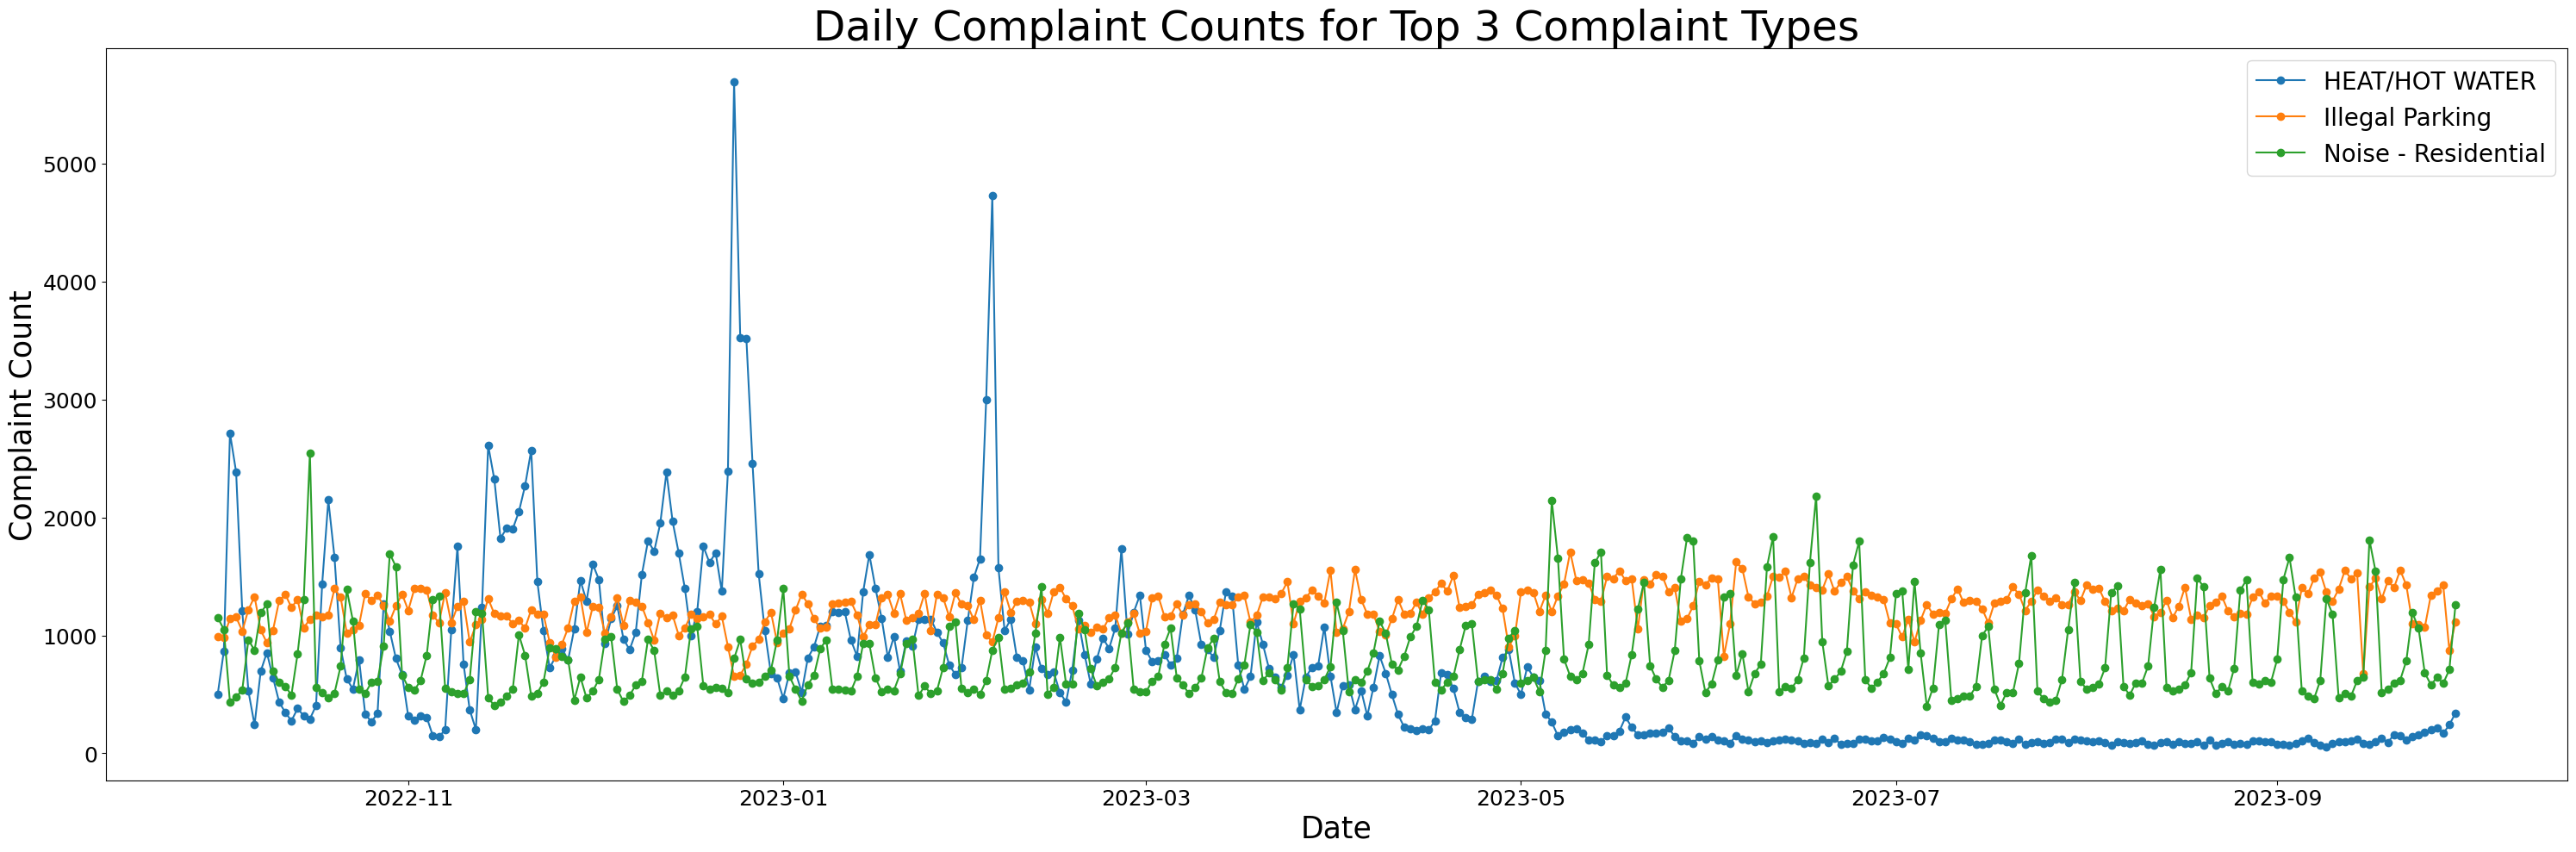

In [55]:
plot_line_chart_for_daily_complaint(daily_data)

### Visualization 2
Create a visualization that shows the number of complaints by complaint type for the top 10 complaints in zip code 10027 for October 1st, 2018 to September 30th, 2023 (inclusive). 

We chose to use histogram since it best record the counts.

In [56]:
def top_complaint_type_and_counts() -> pd.DataFrame:
    """
    Returns:
        pd.DataFrame: A DataFrame containing the top ten complaint types and their respective 
                      counts for the specified zipcode and date range.
    """
    query = '''
    SELECT complaint_type, COUNT(*) AS complaint_count  
    FROM nyc_311 
    WHERE zipcode = '10027'  
    AND date >= '2018-10-01'  
    AND date <= '2023-12-30'  
    GROUP BY complaint_type  
    ORDER BY complaint_count DESC  
    LIMIT 10;
    '''
    engine = create_engine(DB_URL) 
    df = pd.read_sql_query(query, con=engine)
    return df
    

In [57]:
def plot_histogram_for_complaint_type(dataframe) -> None:
    """
    Arguments:
        dataframe (pd.DataFrame): A DataFrame containing the top ten complaint types and their respective 
                                  counts for the specified zipcode and date range.

    Returns:
        None: displays a histogram plot.
    """
    figure, axes = plt.subplots(figsize=(20, 10)) 

    values = dataframe['complaint_type']  
    x = dataframe['complaint_count']  
    axes.tick_params(axis='x', labelsize=14) 
    axes.tick_params(axis='y', labelsize=14)  
    axes.bar(values, x)  #bar plot
    axes.set_title("Complaint Count By Complaint Type",fontsize = 22)  # set title
    plt.xticks(rotation=45)
    plt.xlabel('Complaint Type',fontsize = 18)  
    plt.ylabel('Complaint Count',fontsize = 18) 
    plt.show()

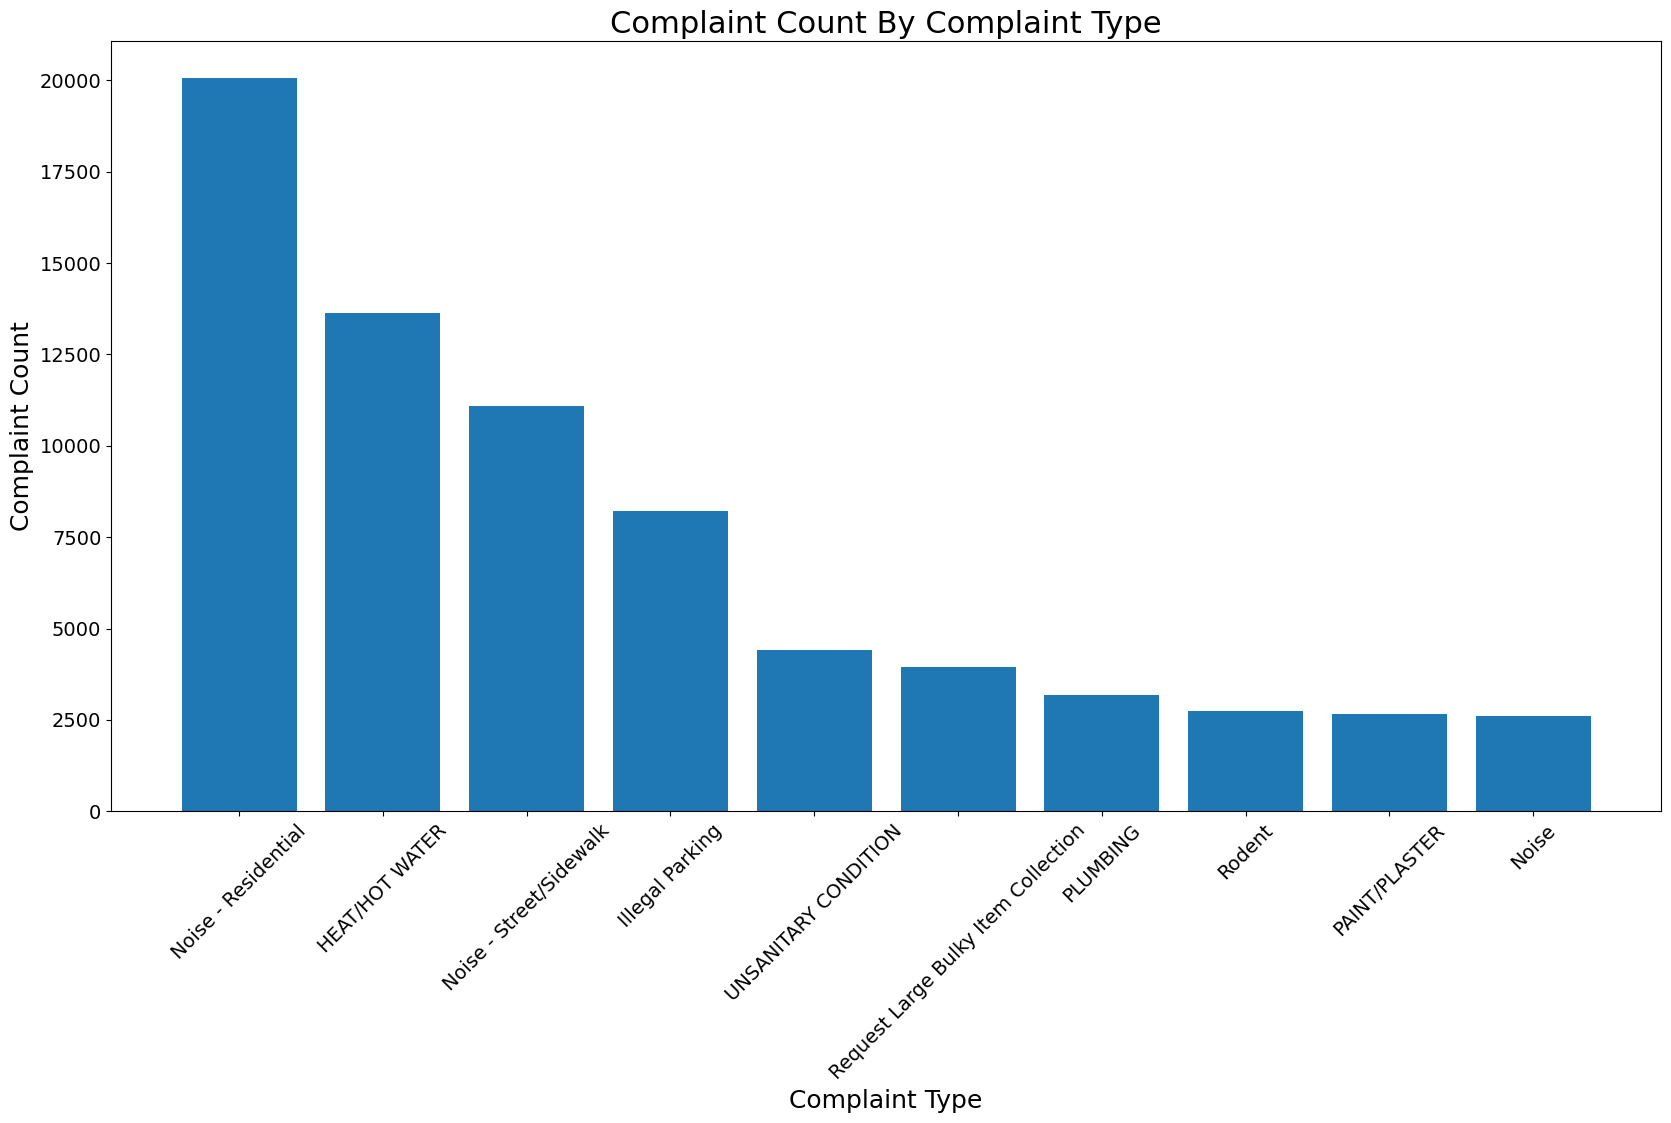

In [58]:
plot_histogram_for_complaint_type(top_complaint_type_and_counts())